In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pymc3 as pm
import corner

from glob import glob
from numpy.random import normal
from scipy.stats import sigmaclip
from scipy.stats import lognorm
from scipy.special import hyp1f1
from scipy.special import gamma
from scipy.interpolate import interp1d
from astropy.coordinates import Distance
from astropy.cosmology import Planck18_arXiv_v2
from frb.dm.igm import average_DM
from frb.dm import igm
from frb.dm import cosmic
from frb.dm import mcmc
from frb import defs
from astropy.cosmology import Planck18 as cosmo
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from astropy.table import Table
from pkg_resources import resource_filename

from observable import do_mcmc
from observable import get_file_zs, get_file_galaxies, observed_bands, draw_Delta

#%matplotlib widget
sns.set_theme(style='whitegrid')

/home/jjahns/anaconda3/envs/py39/lib/python3.9/site-packages/FRB-0.1.dev0-py3.9.egg/frb/halos/hmf.py:51: UserWarning: hmf_emulator not imported.  Hope you are not intending to use the hmf.py module..
  warnings.warn("hmf_emulator not imported.  Hope you are not intending to use the hmf.py module..")


In [2]:
textwidth = 7.0282  # might also be from latex textwidth=17.85162cm columnwidth=8.5744cm
columnwidth = 3.37574803  #3.3

small_size = 8
medium_size = 10
bigger_size = 12

sns.set_theme(style="ticks", context="paper")

plt.rc('font', size=small_size)          # controls default text sizes
plt.rc('axes', titlesize=small_size)     # fontsize of the axes title
plt.rc('axes', labelsize=medium_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=small_size)    # legend fontsize
plt.rc('figure', titlesize=bigger_size)  # fontsize of the figure title


In [3]:
palette = sns.color_palette('Set2')  #sns.color_palette('Spectral', n_colors=5)[::2]  #
sns.set_palette(palette)
palette

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [4]:
# Load FRBs from the pickle files.
n_frbs = 1000
#pickles = sorted(glob('Simulated_FRBs/Old parameter runs/*.pickle'))
pickles = sorted(glob('Simulated_FRBs/*.pickle'))
survey_models, z_models = [], []
for file in pickles:
    # Extract models from file names.
    params = os.path.basename(file)
    params = os.path.splitext(params)[0]
    params = params.split('_', 1)
    survey_models.append(params[0])
    z_models.append(params[1])

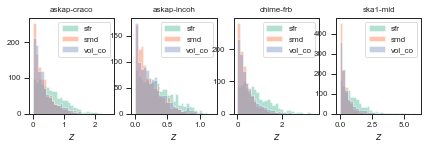

In [5]:
n_models = len(pickles)//3
fig, axs = plt.subplots(1, n_models, figsize=(textwidth, textwidth/3*4.8/6.4))
z_max = [2.5, 1.2, 3.5, 6.]

for i, file in enumerate(pickles):
    frbs = np.load(file, allow_pickle=True)
    frbs = frbs.iloc[:n_frbs]
    ax = axs[i // 3]
    bins = np.linspace(0, z_max[i // 3], 30)
    ax.hist(frbs['z'], label=z_models[i], density=False, bins=bins, histtype='stepfilled', alpha=.5)
    #sns.histplot(frbs['z'], label=z_models[i], bins=bins, ax=ax) #, histtype='stepfilled', alpha=.5, density=False
    ax.set_title(survey_models[i])
    ax.set_xlabel(r"$z$")
    ax.legend()

In [6]:
frbs = np.load(pickles[6], allow_pickle=True)

In [7]:
frbs['z'].max()

3.366460084915161

In [8]:
pickles

['Simulated_FRBs/askap-craco_sfr.pickle',
 'Simulated_FRBs/askap-craco_smd.pickle',
 'Simulated_FRBs/askap-craco_vol_co.pickle',
 'Simulated_FRBs/askap-incoh_sfr.pickle',
 'Simulated_FRBs/askap-incoh_smd.pickle',
 'Simulated_FRBs/askap-incoh_vol_co.pickle',
 'Simulated_FRBs/chime-frb_sfr.pickle',
 'Simulated_FRBs/chime-frb_smd.pickle',
 'Simulated_FRBs/chime-frb_vol_co.pickle',
 'Simulated_FRBs/ska1-mid_sfr.pickle',
 'Simulated_FRBs/ska1-mid_smd.pickle',
 'Simulated_FRBs/ska1-mid_vol_co.pickle']

In [9]:
# Find files with galaxies from GALFORM files and get the redshifts.
gal_files = glob('Galform_galaxies/**/frb.cat', recursive=True)
snap_zs = np.array([get_file_zs(gal_file) for gal_file in gal_files])

# Sort by redshift.
z_order = snap_zs.argsort()
snap_zs = snap_zs[z_order]
if np.any(snap_zs[:-1] == snap_zs[1:]):
    raise ValueError("There are duplicats in the snapshots, it's likely iz105 which is weird.")
gal_files = [gal_files[i] for i in z_order]

In [10]:
gal_files, snap_zs

(['Galform_galaxies/frb.II/iz271/ivol0/frb.cat',
  'Galform_galaxies/frb.II/iz226/ivol0/frb.cat',
  'Galform_galaxies/frb.II/iz207/ivol0/frb.cat',
  'Galform_galaxies/frb.II/iz190/ivol0/frb.cat',
  'Galform_galaxies/frb.II/iz176/ivol0/frb.cat',
  'Galform_galaxies/frb.II/iz155/ivol0/frb.cat',
  'Galform_galaxies/frb.II/iz142/ivol0/frb.cat',
  'Galform_galaxies/frb.II/iz130/ivol0/frb.cat',
  'Galform_galaxies/frb.II/iz120/ivol0/frb.cat',
  'Galform_galaxies/frb.II/iz112/ivol0/frb.cat',
  'Galform_galaxies/frb.II/iz105/ivol0/frb.cat',
  'Galform_galaxies/frb.II/iz82/ivol0/frb.cat'],
 array([0.   , 0.249, 0.496, 0.757, 1.007, 1.496, 2.002, 2.51 , 3.046,
        3.534, 4.008, 6.011]))

In [11]:
# # Create a latex table of snapshots.
# for i, file in enumerate(gal_files):
#     galaxy_pop = get_file_galaxies(file)
#     print(f"{i} & {snap_zs[i]} & {galaxy_pop.shape[0]} \\\\")

In [12]:
radio_survey_names = {"askap-craco" : "ASKAP/CRACO", "askap-incoh" : "ASKAP/ICS", "chime-frb" : "CHIME/FRB", "meerkat" : "MeerKAT", "ska1-mid" : "SKA1-Mid"}
cosm_pops = ["SFR", "SMD", r"$V_\mathrm{C}$"]

Simulated_FRBs/askap-incoh_sfr.pickle
1035 FRBs in file, using only first 1000
Simulated_FRBs/askap-incoh_smd.pickle
1031 FRBs in file, using only first 1000
Simulated_FRBs/askap-incoh_vol_co.pickle
1009 FRBs in file, using only first 1000
ASKAP/ICS + SDSS:
Distance model: SFR, no host: 29.7%, all bands: 41.5%
Distance model: SMD, no host: 12.1%, all bands: 56.4%
Distance model: $V_\mathrm{C}$, no host: 14.6%, all bands: 50.7%
ASKAP/ICS + LSST:
Distance model: SFR, no host: 1.1%, all bands: 91.9%
Distance model: SMD, no host: 0.2%, all bands: 94.4%
Distance model: $V_\mathrm{C}$, no host: 0.4%, all bands: 92.7%
ASKAP/ICS + Euclid:
Distance model: SFR, no host: 1.8%, all bands: 93.2%
Distance model: SMD, no host: 0.6%, all bands: 97.6%
Distance model: $V_\mathrm{C}$, no host: 0.5%, all bands: 97.1%
ASKAP/ICS + DES:
Distance model: SFR, no host: 9.9%, all bands: 83.1%
Distance model: SMD, no host: 3.3%, all bands: 92.6%
Distance model: $V_\mathrm{C}$, no host: 4.2%, all bands: 90.5%
Simu

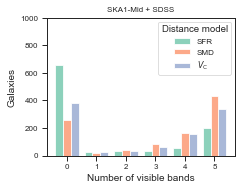

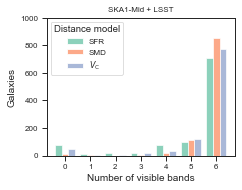

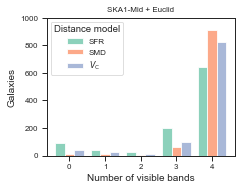

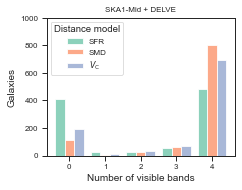

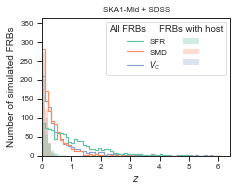

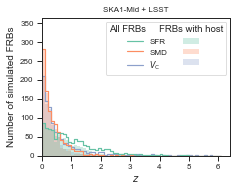

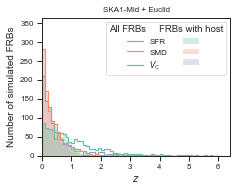

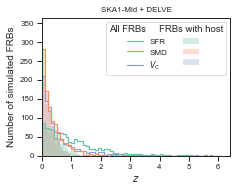

In [15]:
# Loop over FRB surveys and redshift distributions
start_file = 6  # choose from 0, 3, 6, 9 for craco, incoh, chime, ska
n_files = 3
max_z_count = None

for start_file in [3, 0, 6, 9]:
    frb_pops = []
    if not (survey_models[start_file] == survey_models[start_file+1] == survey_models[start_file+2]):
        raise ValueError("You are trying to mix several telescopes into one plot. The naming does not allow this.")
    radio_survey = survey_models[start_file]
    radio_survey_name = radio_survey_names[radio_survey]

    for i_choose in range(start_file, start_file+n_files):
        chosen = pickles[i_choose]

        # Weight galaxy choice depending on file name
        if os.path.splitext(chosen)[0][-3:] == 'sfr':  # last thre letters before extension
            weights = 'mstardot'
        else:
            weights = 'mstars_total'
        print(chosen)

        # Make bins around the catalog snapshots
        bins = np.concatenate((snap_zs[0:1], snap_zs[:-1] + np.diff(snap_zs)/2, snap_zs[-1:] + 50.))

        seed = 42  #42
        rng = np.random.default_rng(seed)

        #n_z_bins = 29   # Three lines and 3 lines at bottom are to test variation between different runs
        #n_observed_sdss = np.zeros([10, n_z_bins], dtype=int)
        #for i in range(10):
        frbs = np.load(chosen, allow_pickle=True)
        print(frbs.shape[0], "FRBs in file, using only first", n_frbs)
        frbs = frbs.iloc[:n_frbs].copy()

        nums_to_draw = np.histogram(frbs['z'], bins=bins)[0]
        relev_snap = nums_to_draw != 0
        snaps = relev_snap.nonzero()[0]

        # Draw galaxies from the GALFORM files. This assumes they are sorted like their redshifts.
        galaxies = []
        for snap, n_draw in zip(snaps, nums_to_draw[relev_snap]):
            galaxy_pop = get_file_galaxies(gal_files[snap])
            galaxy_pop.loc[:, 'redshift'] = snap_zs[snap]
            galaxy_pop.loc[:, 'snapnum'] = snap
            galaxies.append(galaxy_pop.sample(n=n_draw, replace=False, weights=weights, random_state=rng))

        galaxies = pd.concat(galaxies)

        # Order FRBs such that they correspond to galaxies at the same positions.
        frbs.loc[:, 'snapnum'] = np.digitize(frbs['z'].to_numpy(), bins) - 1
        frbs.sort_values('snapnum', ascending=True, inplace=True)

        n_bands_obs_SDSS, n_bands_obs_LSST, n_bands_obs_Euclid, n_bands_obs_DES = observed_bands(frbs, galaxies)

        frbs['n_bands_SDSS'] = n_bands_obs_SDSS.to_numpy()
        frbs['n_bands_LSST'] = n_bands_obs_LSST.to_numpy()
        frbs['n_bands_Euclid'] = n_bands_obs_Euclid.to_numpy()
        frbs['n_bands_DES'] = n_bands_obs_DES.to_numpy()

        # Save to a list to plot several surveys at once.
        frb_pops.append(frbs)

    for i, frbs in enumerate(frb_pops):
        frbs['Distance model'] = cosm_pops[i]
    frb_pops = pd.concat(frb_pops,)

    frb_pops.index = range(frb_pops.shape[0])

    plt.close('all')

    # Make histograms of the visible number of bands
    for survey in ['SDSS', 'LSST', 'Euclid', 'DES']:
        fig, ax = plt.subplots(figsize=(columnwidth, columnwidth/6.4*4.8))

        band_column = 'n_bands_' + survey
        n_bands = frb_pops[band_column].max()
        bins = np.linspace(-.5, n_bands+.5, n_bands+2)
        sns.histplot(data=frb_pops, x=band_column, hue='Distance model', 
                     bins=bins, multiple='dodge', 
                     fill=True, shrink=.8, )  #palette=palette[:n_files]

        # Name axes etc.
        ax.set_xlabel('Number of visible bands')
        ax.set_ylabel('Galaxies')
        ax.set_xticks(range(0, n_bands+1))
        ax.set_ylim(0, n_frbs)
        #ax.legend()
        ax.set_title(radio_survey_name + " + " + survey)
        if survey == 'DES':
            ax.set_title(radio_survey_name + " + DELVE")
        fig.savefig(f"figures/n_bands_{radio_survey}_{survey}.png", dpi=300, bbox_inches='tight')

        # Print the basic stats
        print(radio_survey_name + " + " + survey + ":")
        for model in cosm_pops:
            frbs = frb_pops[frb_pops['Distance model'] == model]
            n_band_hist = np.histogram(frbs[band_column], bins)[0]
            print(f"Distance model: {model}, no host: {n_band_hist[0]/n_frbs:.1%}, all bands: {n_band_hist[-1]/n_frbs:.1%}")

    # Make histograms of FRBs in redshift.
    for survey in ['SDSS', 'LSST', 'Euclid', 'DES']:
        # Get the band numbers out of the data frame
        band_column = 'n_bands_' + survey
        n_bands_obs = frb_pops[band_column]
        n_bands = n_bands_obs.max()

        fig, ax = plt.subplots(figsize=(columnwidth, columnwidth/6.4*4.8))

        # Fix bin width. Put one extra bin on each side to draw the line back to the bottom.
        binwidth = 0.1
        bins = np.arange(0-binwidth, z_max[i_choose//3]+2*binwidth, binwidth)

        sns.histplot(data=frb_pops.iloc[::-1], x='z', hue='Distance model', hue_order=cosm_pops[:n_files],
                     bins=bins, element='step', fill=False, legend=True, ax=ax)  # label="FRBs" palette=palette[:n_files], 
        handles_hist1 = ax.legend_.legendHandles  # save for later

        sns.histplot(data=frb_pops.loc[n_bands_obs.to_numpy() == n_bands].iloc[::-1].reindex(), 
                     x='z', hue='Distance model', hue_order=cosm_pops[:n_files],
                     bins=bins, element='step', alpha=.3,
                     linewidth=0, legend=True, ax=ax) #palette=palette[:n_files],  # label="Host visible"

        ax.set_xlabel('$z$')
        ax.set_ylabel('Number of simulated FRBs')
        ax.set_title(radio_survey_name + " + " + survey)  #, y=.9
        if survey == 'DES':
            ax.set_title(radio_survey_name + " + DELVE")
        
        # Set same redshift range except for SKA
        if radio_survey == 'ska1-mid':
            ax.set_xlim(0, None)
        else:
            ax.set_xlim(0, 3.5)
            ax.set_xticks([0,1,2,3])
        
        # Set fixed y-limits from the first bin in ASKAP/ICS with SMD
        if (radio_survey == 'askap-incoh') and not max_z_count:
            max_z_count = np.count_nonzero(frb_pops.loc[frb_pops['Distance model'] == 'SMD', 'z'] < binwidth) * 26/25  # add 4%
        ax.set_ylim(0, max_z_count)

        # For someweird reason calling ax.legend displays the handles in reverse order, the following puts them in right order
        # inspired by https://github.com/mwaskom/seaborn/issues/2280
        old_legend = ax.legend_
        handles_hist2 = old_legend.legendHandles
        handles = handles_hist1 + handles_hist2
        labels = [t.get_text() for t in old_legend.get_texts()]

        # Finally make the new legend.
        l = ax.legend(title="All FRBs     FRBs with host",
                  handles=handles,
                  labels=labels + len(labels)*["",],  #cosm_pops[:n_files],  loc=(.34, .5),
                  ncol=2,)

        fig.savefig(f"figures/visible_galaxies_{radio_survey}_{survey}.png", dpi=300, bbox_inches='tight')


In [16]:
# Loop over FRB surveys and redshift distributions
start_file = 6  # choose from 0, 3, 6, 9 for craco, incoh, chime, ska
n_files = 3
max_z_count = None

# Initiate two plots with all the radio (rows) and optical (cols) surveys.

# for plt_row, start_file in enumerate([3, 0, 6, 9]):
start_file = 3
frb_pops = []
if not (survey_models[start_file] == survey_models[start_file+1] == survey_models[start_file+2]):
    raise ValueError("You are trying to mix several telescopes into one plot. The naming does not allow this.")
radio_survey = survey_models[start_file]
radio_survey_name = radio_survey_names[radio_survey]

for i_choose in range(start_file, start_file+n_files):
    chosen = pickles[i_choose]

    # Weight galaxy choice depending on file name
    if os.path.splitext(chosen)[0][-3:] == 'sfr':  # last thre letters before extension
        weights = 'mstardot'
    else:
        weights = 'mstars_total'
    print(chosen)

    # Make bins around the catalog snapshots
    bins = np.concatenate((snap_zs[0:1], snap_zs[:-1] + np.diff(snap_zs)/2, snap_zs[-1:] + 50.))

    seed = 42  #42
    rng = np.random.default_rng(seed)

    #n_z_bins = 29   # Three lines and 3 lines at bottom are to test variation between different runs
    #n_observed_sdss = np.zeros([10, n_z_bins], dtype=int)
    #for i in range(10):
    frbs = np.load(chosen, allow_pickle=True)
    print(frbs.shape[0], "FRBs in file, using only first", n_frbs)
    frbs = frbs.iloc[:n_frbs].copy()

    nums_to_draw = np.histogram(frbs['z'], bins=bins)[0]
    relev_snap = nums_to_draw != 0
    snaps = relev_snap.nonzero()[0]

    # Draw galaxies from the GALFORM files. This assumes they are sorted like their redshifts.
    galaxies = []
    for snap, n_draw in zip(snaps, nums_to_draw[relev_snap]):
        galaxy_pop = get_file_galaxies(gal_files[snap])
        galaxy_pop.loc[:, 'redshift'] = snap_zs[snap]
        galaxy_pop.loc[:, 'snapnum'] = snap
        galaxies.append(galaxy_pop.sample(n=n_draw, replace=False, weights=weights, random_state=rng))

    galaxies = pd.concat(galaxies)

    # Order FRBs such that they correspond to galaxies at the same positions.
    frbs.loc[:, 'snapnum'] = np.digitize(frbs['z'].to_numpy(), bins) - 1
    frbs.sort_values('snapnum', ascending=True, inplace=True)

    n_bands_obs_SDSS, n_bands_obs_LSST, n_bands_obs_Euclid, n_bands_obs_DES = observed_bands(frbs, galaxies)

    frbs['n_bands_SDSS'] = n_bands_obs_SDSS.to_numpy()
    frbs['n_bands_LSST'] = n_bands_obs_LSST.to_numpy()
    frbs['n_bands_Euclid'] = n_bands_obs_Euclid.to_numpy()
    frbs['n_bands_DES'] = n_bands_obs_DES.to_numpy()

    # Save to a list to plot several surveys at once.
    frb_pops.append(frbs)

for i, frbs in enumerate(frb_pops):
    frbs['Distance model'] = cosm_pops[i]
frb_pops = pd.concat(frb_pops,)

frb_pops.index = range(frb_pops.shape[0])
 

Simulated_FRBs/askap-incoh_sfr.pickle
1035 FRBs in file, using only first 1000
Simulated_FRBs/askap-incoh_smd.pickle
1031 FRBs in file, using only first 1000
Simulated_FRBs/askap-incoh_vol_co.pickle
1009 FRBs in file, using only first 1000


ASKAP/ICS + SDSS:
Distance model: SFR, no host: 29.7%, all bands: 41.5%
Distance model: SMD, no host: 12.1%, all bands: 56.4%
Distance model: $V_\mathrm{C}$, no host: 14.6%, all bands: 50.7%
ASKAP/ICS + LSST:
Distance model: SFR, no host: 1.1%, all bands: 91.9%
Distance model: SMD, no host: 0.2%, all bands: 94.4%
Distance model: $V_\mathrm{C}$, no host: 0.4%, all bands: 92.7%
ASKAP/ICS + Euclid:
Distance model: SFR, no host: 1.8%, all bands: 93.2%
Distance model: SMD, no host: 0.6%, all bands: 97.6%
Distance model: $V_\mathrm{C}$, no host: 0.5%, all bands: 97.1%
ASKAP/ICS + DES:
Distance model: SFR, no host: 9.9%, all bands: 83.1%
Distance model: SMD, no host: 3.3%, all bands: 92.6%
Distance model: $V_\mathrm{C}$, no host: 4.2%, all bands: 90.5%
ASKAP/ICS + SDSS:
Distance model: SFR, no host: 29.7%, all bands: 41.5%
Distance model: SMD, no host: 12.1%, all bands: 56.4%
Distance model: $V_\mathrm{C}$, no host: 14.6%, all bands: 50.7%
ASKAP/ICS + LSST:
Distance model: SFR, no host: 1.1%,

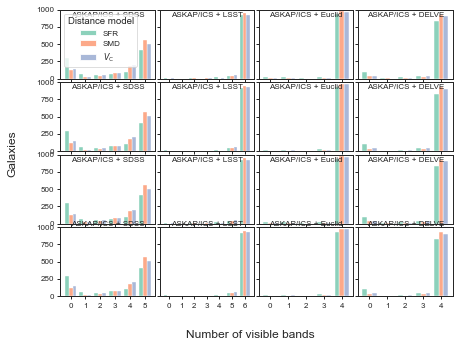

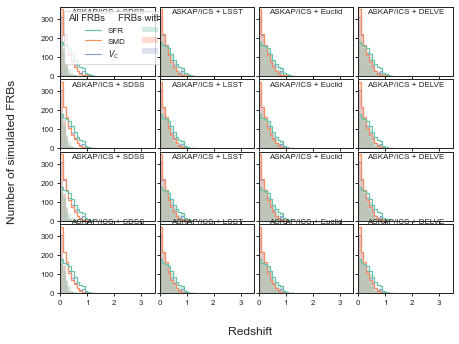

In [17]:
fig_bands, axs_bands = plt.subplots(4, 4, sharex='col', sharey=True, gridspec_kw={'hspace':0.05, 'wspace':0.05}, 
                                    figsize=(textwidth, textwidth/6.4*4.8), )
fig_zs, axs_zs = plt.subplots(4, 4, sharex=True, sharey=True, gridspec_kw={'hspace':0.05, 'wspace':0.05}, 
                              figsize=(textwidth, textwidth/6.4*4.8))

title_pad = -7
for plt_row, start_file in enumerate([3, 0, 6, 9]):
    # Make histograms of the visible number of bands
    for plt_col, survey in enumerate(['SDSS', 'LSST', 'Euclid', 'DES']):
        # fig, ax = plt.subplots(figsize=(columnwidth, columnwidth/6.4*4.8))
        ax = axs_bands[plt_row, plt_col]

        band_column = 'n_bands_' + survey
        n_bands = frb_pops[band_column].max()
        bins = np.linspace(-.5, n_bands+.5, n_bands+2)
        sns.histplot(data=frb_pops, x=band_column, hue='Distance model', 
                     bins=bins, multiple='dodge', 
                     fill=True, shrink=.8, ax=ax)  #palette=palette[:n_files]

        # Name axes etc.
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.tick_params('both', length=3)
        ax.set_xticks(range(0, n_bands+1))
        ax.set_ylim(0, n_frbs)
        ax.set_title(radio_survey_name + " + " + survey, pad=title_pad)
        if survey == 'DES':
            ax.set_title(radio_survey_name + " + DELVE", pad=title_pad)

        if not (plt_col == plt_row == 0):
            ax.get_legend().remove()

        # Print the basic stats
        print(radio_survey_name + " + " + survey + ":")
        for model in cosm_pops:
            frbs = frb_pops[frb_pops['Distance model'] == model]
            n_band_hist = np.histogram(frbs[band_column], bins)[0]
            print(f"Distance model: {model}, no host: {n_band_hist[0]/n_frbs:.1%}, all bands: {n_band_hist[-1]/n_frbs:.1%}")

    # Make histograms of FRBs in redshift.
    for plt_col, survey in enumerate(['SDSS', 'LSST', 'Euclid', 'DES']):
        # Get the band numbers out of the data frame
        band_column = 'n_bands_' + survey
        n_bands_obs = frb_pops[band_column]
        n_bands = n_bands_obs.max()

        # fig, ax = plt.subplots(figsize=(columnwidth, columnwidth/6.4*4.8))
        ax = axs_zs[plt_row, plt_col]

        # Fix bin width. Put one extra bin on each side to draw the line back to the bottom.
        binwidth = 0.1
        bins = np.arange(0-binwidth, z_max[i_choose//3]+2*binwidth, binwidth)

        sns.histplot(data=frb_pops.iloc[::-1], x='z', hue='Distance model', hue_order=cosm_pops[:n_files],
                     bins=bins, element='step', fill=False, legend=True, ax=ax)  # label="FRBs" palette=palette[:n_files], 
        handles_hist1 = ax.legend_.legendHandles  # save for later

        sns.histplot(data=frb_pops.loc[n_bands_obs.to_numpy() == n_bands].iloc[::-1].reindex(), 
                     x='z', hue='Distance model', hue_order=cosm_pops[:n_files],
                     bins=bins, element='step', alpha=.3,
                     linewidth=0, legend=True, ax=ax) #palette=palette[:n_files],  # label="Host visible"

        ax.set_xlabel(None)
        ax.set_ylabel(None)
        
        ax.set_title(radio_survey_name + " + " + survey, pad=title_pad)  #, y=.9
        if survey == 'DES':
            ax.set_title(radio_survey_name + " + DELVE", pad=title_pad)

        ax.tick_params('both', length=3)
        
        # Set same redshift range except for SKA
        if radio_survey == 'ska1-mid':
            ax.sharex(False)
            ax.set_xlim(0, None)
        else:
            ax.set_xlim(0, 3.5)
            ax.set_xticks([0,1,2,3])
        
        # Set fixed y-limits from the first bin in ASKAP/ICS with SMD
        if (radio_survey == 'askap-incoh') and not max_z_count:
            max_z_count = np.count_nonzero(frb_pops.loc[frb_pops['Distance model'] == 'SMD', 'z'] < binwidth) * 26/25  # add 4%
        ax.set_ylim(0, max_z_count)

        # For someweird reason calling ax.legend displays the handles in reverse order, the following puts them in right order
        # inspired by https://github.com/mwaskom/seaborn/issues/2280
        if (plt_col == 0) and (plt_row == 0):
            old_legend = ax.legend_
            handles_hist2 = old_legend.legendHandles
            handles = handles_hist1 + handles_hist2
            labels = [t.get_text() for t in old_legend.get_texts()]

            # Finally make the new legend.
            l = ax.legend(title="All FRBs     FRBs with host",
                      handles=handles,
                      labels=labels + len(labels)*["",],
                      ncol=2,)
        else:
            ax.get_legend().remove()
        
fig_bands.supxlabel('Number of visible bands')
fig_bands.supylabel('Galaxies')
fig_zs.supxlabel('Redshift')
fig_zs.supylabel('Number of simulated FRBs')

fig_bands.savefig(f"figures/n_bands.png", dpi=300, bbox_inches='tight')
fig_zs.savefig(f"figures/visible_galaxies.png", dpi=300, bbox_inches='tight')
